# Class exercises for EarthAI notebooks

This is an adaptation for the in-class exercises for EarthAI notebooks that we went over in class the week of March 3.

## Load in libraries

In [2]:
from earthai.init import *
import folium
import geopandas
# from pyspark.sql.functions import lit
import pyspark.sql.functions as F
from shapely.geometry import Point


Importing EarthAI libraries.
EarthAI version 1.3.0; RasterFrames version 0.9.0.dev+astraea.1ce1ff3; PySpark version 2.4.4

Creating SparkSession...
  SparkSession is available as `spark`.


## Load in administrative districts shape

We can pick out a particular district (2838) and have a look at it's shape.  We want to use the center point of this district to select a time series of MODIS data

First we select the district and look at it

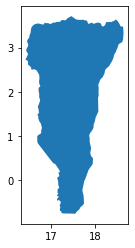

In [3]:
geo_admin_url = 'https://raw.githubusercontent.com/datasets/geo-ne-admin1/master/data/admin1.geojson'
adm1 = geopandas.read_file(geo_admin_url)#.drop(columns='id') 
# adm1_2838 = adm1[adm1.id.isin(['2838', '3342'])]  # more than one
adm1_2838 = adm1[adm1.id.isin(['2838'])]  # just one
adm1_2838.plot()  # matplotlib, if so desired (better is a folium map below)
# print(adm1_2838)

We can use the `centroid` function of geopandas to extract the center point of the district. `astype(str)` converts it to string. 

In [4]:
adm1_2838.centroid.astype(str)

700    POINT (17.44786430536906 1.925028617294588)
dtype: object

Note that it has an index value of 700 next to it. We use to select it by index value to get just the text with the point value

In [5]:
pt = adm1_2838.centroid.astype(str)[700]
pt

'POINT (17.44786430536906 1.925028617294588)'

## Create a catalog

We can use the point now to help create a catalog. We want all daily MODIS images (mcd43a4) for the year 2019 that intersect that point

In [6]:
catalog = earth_ondemand.read_catalog(
    geo = pt,
    #geo = 'POINT(15.6 0.02)', # we could have specified a point manually also
    #geo = adm1_2838,  # or intersected with the district polygon also
    start_datetime = '2019-01-01',
    end_datetime = '2019-12-31',
    max_cloud_cover = 100,
    collections = 'mcd43a4', # from the "id" field
)

100%|██████████| 365/365 [00:01<00:00, 242.70it/s]


Running the code below gives you a look at the catalog's attributes

In [9]:
print(type(catalog))
print(catalog.columns)
print('DataFrame `catalog` has', len(catalog), 'rows and ', len(catalog.id.unique()), 'distinct scenes ids')

<class 'geopandas.geodataframe.GeoDataFrame'>
Index(['eod_collection_attribution', 'eod_collection_display_name',
       'eod_collection_family', 'eod_collection_family_display_name',
       'eod_epsg4326_geometry_simplified', 'eod_grid_id', 'created',
       'datetime', 'eo_cloud_cover', 'eo_gsd', 'eo_instrument', 'proj_crs',
       'proj_geometry', 'updated', 'B06qa', 'B01', 'B05', 'B02', 'B01qa',
       'B06', 'B02qa', 'B07qa', 'B05qa', 'B03qa', 'B03', 'B04', 'B07', 'B04qa',
       'eod_thumbnail', 'collection', 'geometry', 'id'],
      dtype='object')
DataFrame `catalog` has 365 rows and  365 distinct scenes ids


Running this shows us what bands are there. It is commented out because we don't want to run it, and just know that it tells us that we want the blue channel's quality band ('B03qa')

In [32]:
# earth_ondemand.bands('mcd43a4')

## Read the catalog into spark

Now we load up the data into RasterFrames, so we can analyze.  We specify the band we want, and rename it to 'qual'

In [7]:
df = spark.read.raster(catalog, catalog_col_names=['B03qa'])\
          .withColumnRenamed('B03qa', 'qual')

Note that this process is lazy. No analysis is done until we need the results of an analysis.  Same with the next step, in which we apply a mask

### Find how many pixels are > 0

This is like masking, but filtering pixels > 0 to get areas of low quality, which suggests low quality. 

In [8]:
masked = df.withColumn('clouds', rf_local_greater('qual', 0))
print(masked.columns)

['B03qa_path', 'qual', 'eod_collection_attribution', 'eod_collection_display_name', 'eod_collection_family', 'eod_collection_family_display_name', 'eod_epsg4326_geometry_simplified', 'eod_grid_id', 'created', 'datetime', 'eo_cloud_cover', 'eo_gsd', 'eo_instrument', 'proj_crs', 'proj_geometry', 'updated', 'B06qa', 'B01', 'B05', 'B02', 'B01qa', 'B06', 'B02qa', 'B07qa', 'B05qa', 'B03', 'B04', 'B07', 'B04qa', 'eod_thumbnail', 'collection', 'geometry', 'id', 'clouds']


Let's apply a histogram to one of these to see what the distribution of values is like

root
 |-- bins: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- value: double (nullable = false)
 |    |    |-- count: long (nullable = false)



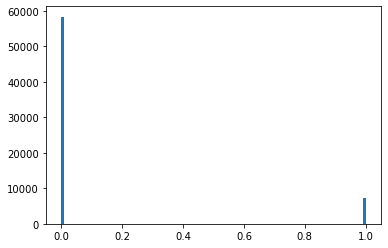

In [9]:
import matplotlib.pyplot as plt
hist_df = masked.select(rf_tile_histogram('clouds')['bins'].alias('bins'))
hist_df.printSchema()

bins_row = hist_df.first()
values = [int(bin['value']) for bin in bins_row.bins]
counts = [int(bin['count']) for bin in bins_row.bins]

plt.hist(values, weights=counts, bins=100)
plt.show()

Let's look at one of the masked tiles. This is new--we didn't do this in class, but it is more efficient than the process we used, which was to look at the RasterFrame contents, which was a bit slow.  We convert here the first image to a tile and display it

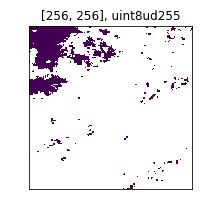

In [10]:
t = masked.select(rf_tile('qual').alias('clouds')).first()['clouds']
display(t)

## Exercises

The exercises we want to do on your own are as follows. 

We have created the derivatives necessary to create a time series to examine how cloudy it is over the course of the year in this part of the Congo.

This will require you to:

1. Create an image time series, by calculating the average level of cloudiness across weeks.

    - To do this, you will need to:
        - Apply the following functions on the `masked` object: `weekofyear`, `agg`, and `rf_agg_mean`
        - The following code, from the `time-series.ipynb`, can help (see the [web version of](https://rasterframes.io//time-series.html) this notebook also):
    
        ```python
        time_series = rf_park_tile \
            .groupby(
                year('acquisition_date').alias('year'), 
                weekofyear('acquisition_date').alias('week')) \
            .agg(rf_agg_mean('ndvi_masked').alias('ndvi'))
        ```
        This shows how to do this over an NDVI time series. We are doing this by applying to our masked quality time series. 

2. Plot that as a time series

    - The same time series has the example you need, which use plotly to create the time series plot. Before doing that, however, you have to convert the RasterFrames object to pandas using `toPandas`, e.g. 
    
    ```python
    time_series_pdf = time_series.toPandas()
    ```
    
    - Then use plotly. From the same time-series example. Change the titles to relevant text for this cloudiness plot
    
    ```python
    import matplotlib.pyplot as plt
    time_series_pdf.sort_values('week', inplace=True)
    plt.plot(time_series_pdf['week'], time_series_pdf['ndvi'], 'go-')
    plt.ylim([-1, 1])  # note I added this to the example. You can set this [0, 1] for cloudiness
    plt.xlabel('Week of year, 2018')
    plt.ylabel('NDVI')
    plt.title('Cuyahoga Valley NP Green-up')
    ```
    
3. Do the same, but calculating the monthly mean cloudiness, and plot the time series of that also


    **Note**: The conversion step `toPandas()` is what takes the longest. 
    
4. **Bonus**, for the adventurous (and because I haven't worked out a solution for this yet).  Try and use `rf_agg_local_mean` to get a monthly raster composite showing cloud cover frequency. To do that, you will have to apply this to the time series step.  Pointers for how to do that are in the `aggregation.ipynb` notebook and the [online version](https://rasterframes.io/aggregation.html).  However, this is not trivial, because it doesn't work when the images have different extents. Even though these are the same MODIS tiles, I guess the extent are different, so to make this work, the extents of the images would have to be made the same.  I am guessing that entails cropping and possibly resampling each image to a common extent first, and then analyzing the time series. Maybe best to try this just on one or two months worth of data to start. 

## Key
### Weekly time series
Now that we have a mask, let's create a time series

This is a new markdown cell

In [11]:
time_series = masked.groupBy(F.weekofyear('datetime').alias('week')) \
                            .agg(rf_agg_mean('clouds').alias('clouds'))

Convert the time series to a `pandas` DataFrame

In [12]:
# print(time_series.columns)
time_series_pdf = time_series.toPandas()

Text(0.5, 1.0, 'Monthly cloud cover')

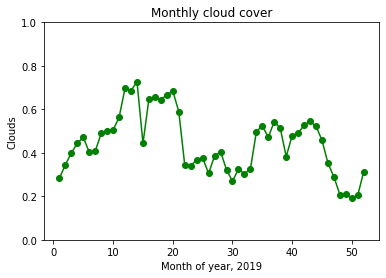

In [13]:
import matplotlib.pyplot as plt
time_series_pdf.sort_values('week', inplace=True)
plt.plot(time_series_pdf['week'], time_series_pdf['clouds'], 'go-')
plt.ylim([0, 1])
plt.xlabel('Month of year, 2019')
plt.ylabel('Clouds')
plt.title('Monthly cloud cover')

### Monthly time series

In [80]:
mtime_series = masked.groupBy(F.month('datetime').alias('month')) \
                              .agg(rf_agg_mean('clouds').alias('clouds'))
mtime_series_pdf = mtime_series.toPandas()

Monthly plot

Text(0.5, 1.0, 'Monthly cloud cover')

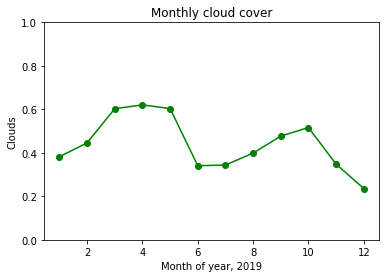

In [81]:
mtime_series_pdf.sort_values('month', inplace=True)
plt.plot(mtime_series_pdf['month'], mtime_series_pdf['clouds'], 'go-')
plt.ylim([0, 1])
plt.xlabel('Month of year, 2019')
plt.ylabel('Clouds')
plt.title('Monthly cloud cover')